# CodeLab 4 - Extreme Events analysis of weather forecasts via universal approximators


Extreme precipitation usually leads to substantial impacts. Floods in the Netherlands, Belgium
and Germany in the summer of 2021 has caused loss of lives, destruction of infrastructures, and long-term effect on economics. To avoid such disasters, it is essential to develop a reliable and accurate method to predict heavy rain. In this CodeLab, we will explore and analyze rainy events in weather forecasts using features universal approximators in classification and regression techniques. Notably, we will study a dataset containing real precipitation maps of the Netherlands. We will process such datasets to create different versions that present different balances between rainy and not rainy events. Moreover, we will downsample the given dataset to apply regression techniques. 

In [ ]:
from matplotlib import pyplot as plt
from zipfile import ZipFile
import numpy as np
import cv2
import os 
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from sklearn.utils import resample
from math import sqrt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, accuracy_score, roc_curve, precision_recall_curve, PrecisionRecallDisplay, roc_auc_score, plot_roc_curve, confusion_matrix, precision_score, recall_score, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
from google.colab import drive
drive.mount('/drive')

import warnings
warnings.filterwarnings("ignore")

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


# Task 1 - Data processing


The dataset contains precipitation images of 2017 in ‘png’ format. Exploring the dataset and seeing
what samples look like is a good idea. First, upload the zip file "dataset_codelab_4" to Jupyter
environment and unzip the file with the given code. Note: Unzipping operation might take up to
10 minutes, do not interrupt the process; you have to do unzipping only once.

In [ ]:
a = 1 #Control variable for you to unzip or not 
if a == 1: 
    with ZipFile('/drive/My Drive/ML/RAD_NL25_RAP_10min.zip', 'r') as zipObj:
       # Extract all the contents of zip file in different directory
       zipObj.extractall()
       print('File is unzipped') 

File is unzipped


Use the given function to retrieve the given sample. Print out the shape of the image and plot using
plt.imshow() function.

(64, 64)


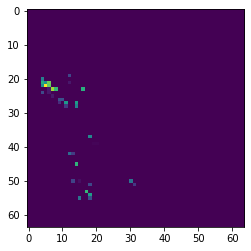

In [ ]:
img = cv2.imread('RAD_NL25_RAP_10min/2017/10/RAD_NL25_RAP_10min_201710010630.png', cv2.IMREAD_GRAYSCALE)/255
print(img.shape)
plt.imshow(img)

Every sample is defined as png file, as the format of the defined name is "RAD_NL25_RAP_-
10min_" + year + month + day + hour + minute. Let’s define the years, months, days, hours,
and minutes to extract all images in a structured way. In order to reduce the size of the dataset, we
have set the minutes portion as 0. Months and hours variables are divided by 100 to obtain strings
from the last 2 decimal digits. 

In [ ]:
#Dataset name
years = [2017]
months = np.linspace(1, 12, 12)/100
Days_n = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
hours = np.linspace(0, 23, 24)/100
minutes = 0  

In [ ]:
minute = ("%.2f" % minutes)[2:]
print(minute)

00


Use nested for loop structure to read images sequentially and insert
them into a NumPy array called "images". Use cv2.imread() function to read images that require
string concatenation to obtain the file path (Check the first example of how it is called, Python
strings: https://docs.python.org/3/library/string.html).


In [ ]:
#Retrieve data
i = 0
j = 0
f = 0
images = np.zeros((8119, 64, 64), float)
year = years[0]
for month in months:
  month = ('%.2f' %month)[2: ]
  days = Days_n[int(month) - 1]
  i = i + 1
  for day in range(1, days + 1):
    day = ('%.2f' %(day/100))[2: ]
    for hour in hours:
      hour = ('%.2f' %hour)[2: ]
      filename = 'RAD_NL25_RAP_10min/2017/' + month + '/RAD_NL25_RAP_10min_' + str(year) + month + day + hour + minute + '.png' #selected sample
      if cv2.imread(filename) is not None:
        f = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        images[j] = f
        j = j + 1
print(j)

8119


#### Dataset balancing and downsampling

Once you collected all images into a unique tensor (3d array), we can preprocess the data to use
them as we want. We are going to create six different versions of the dataset. We’ll first change
the balance between rainy images and not rainy ones. Then we will downsample the images from
64x64 to 8x8 in order to use them for regression tasks.
<br>First, we should preprocess and investigate the data by taking the average and sorting it.
<br>• Subtract 33 from all images in the dataset to obtain minimum (dry conditions) as zero.
<br>• Compute the average precipitation of each image and store it in the array "avg_data".
<br>• Sort the average precipitation in ascending order.
<br>• Compute the mean of the entire dataset.
<br>• Calculate and print out the sample portion that is higher than the threshold.

In [ ]:
#Preprocess
dataset = images - 33  #center the dataset to 0
avg_data = np.zeros(dataset.shape[0], float)
for i in range(dataset.shape[0]):
  avg_data[i] = np.average(dataset[i])
avg_sorted = np.sort(avg_data) # Sort avg to have precipitation pictures in ascending order 
avg_all = np.mean(avg_data) # Mean of the whole dataset
avg_index = sorted(range(avg_data.shape[0]), key=lambda k: avg_data[k])

Heavy rain condition is selected as any processed image that contains an average greyscale pixel
value of more than 3. 
<br>Plot the following variables in the same figure: Sorted average precipitation,
dataset mean, and the threshold value (3).

avg_precipitations= [0.29101562 0.36230469 0.13696289 ... 3.83276367 1.92993164 2.05639648]


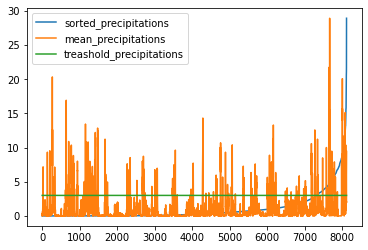

In [ ]:
plt.plot(avg_sorted, label='sorted_precipitations')
plt.plot(avg_data, label='mean_precipitations')
plt.plot([3] * dataset.shape[0], label='treashold_precipitations')
print('avg_precipitations=', avg_data)
plt.legend()

In [ ]:
size_high = (avg_data > 3).sum()
portion = size_high/dataset.shape[0]
print(portion)

0.09853430225397217


Dataset distribution shows us a significant imbalance between heavy rain and regular conditions
which is an expected outcome. However, this situation could cause a certain bias in our machine
learning models, reducing the performance. Although there are many methods to solve the imbalance, we will apply downsampling to the majority class.

<br>The balanced dataset contains 40% of the original dataset. Not to lose any information from the
heavy rain conditions, we should retrieve the top 20% of samples from the sorted average vector.
From the rest you can use the resample(X, replace = F alse, n_samples = N, random_state =
4720) function from sklearn to sample. (Hint: you can use indices of average vector to obtain both
sample cases.)


In [ ]:
#Balanced dataset
balanced_dataset_index_28 = avg_index[: int(dataset.shape[0] * 0.8) - 1] #Index of top 80%
top_20 = avg_index[int(dataset.shape[0] * 0.8) - 1: ] # Retrieve indexes of top 20% 
rest_80 = balanced_dataset_index_28 # Retrieve indexes of below 80%
rest_20 = resample(rest_80, replace=False, n_samples=int(dataset.shape[0] * 0.2), random_state=4720)
balanced_ind_28 = top_20 + rest_20
b_dataset_28 = dataset[balanced_ind_28]

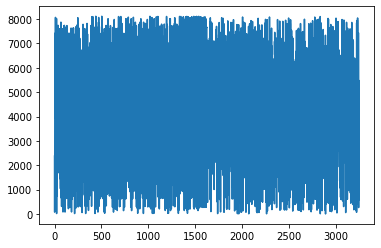

In [ ]:
plt.plot(balanced_ind_28)

Apply the same procedure to obtain 60% of the original dataset where the top 30% is directly
included and another 30% is sampled from the rest (70%), called lightly balanced.

In [ ]:
#Lightly balanced dataset
balanced_dataset_index_37 = avg_index[: int(dataset.shape[0] * 0.7) - 1] #Index of top 70%
top_30 = avg_index[int(dataset.shape[0] * 0.7) - 1: ] # Retrieve indexes of top 30% 
rest_70 = balanced_dataset_index_37 # Retrieve indexes of below 70%
rest_30 = resample(rest_70, replace=False, n_samples=int(dataset.shape[0] * 0.3), random_state=4720)
balanced_ind_37 = top_30 + rest_30
b_dataset_37 = dataset[balanced_ind_37]
print(balanced_ind_37)

[5697, 695, 6556, 7366, 6015, 6993, 2377, 511, 2541, 7225, 2607, 2362, 4333, 4440, 5824, 5744, 7626, 2369, 1200, 1263, 4558, 7003, 7317, 6717, 1128, 5629, 2938, 580, 4255, 3044, 3078, 7770, 2704, 4431, 2565, 8025, 6445, 7639, 4956, 7688, 1127, 2933, 8105, 7503, 4246, 5358, 7044, 5670, 6866, 4080, 7151, 6872, 2776, 5822, 749, 3412, 5075, 324, 5649, 5357, 7497, 6769, 7008, 5743, 2921, 6705, 7403, 1129, 4448, 6697, 4600, 5650, 7266, 6870, 6759, 6719, 68, 73, 1207, 7259, 1713, 6040, 341, 5770, 1248, 4722, 6089, 306, 2948, 4818, 7002, 4712, 85, 1432, 5519, 6034, 6531, 4015, 243, 3016, 4489, 5095, 6270, 6696, 74, 7441, 7982, 317, 2581, 4544, 8024, 7169, 6105, 1500, 3985, 7489, 2359, 7219, 6326, 342, 3063, 6597, 2847, 5768, 7336, 4446, 7258, 4540, 5678, 1158, 3955, 4817, 3294, 954, 194, 4825, 4499, 7163, 1306, 5129, 244, 6649, 6197, 1390, 514, 2750, 2551, 7840, 7226, 3293, 3830, 91, 7682, 2430, 841, 97, 953, 2765, 7630, 2332, 1942, 2943, 798, 8041, 2598, 5371, 5663, 7573, 8031, 1747, 2949, 73

After obtaining 3 datasets, let’s create the corresponding label vectors. Images with mean lower
than the heavy rain threshold (3.0) are labelled as 0 and higher cases as 1. Create 3 different label
vectors correspond to each dataset.

In [ ]:
#Label vectors
y_data = (avg_data > 3) * 1
y_data_balanced = (avg_data[balanced_ind_28] > 3) * 1
y_data_lbalanced = (avg_data[balanced_ind_37] > 3) * 1

Still our datasets are large for processing so we will reduce image size from 64x64 to 8x8. Use
cv2.resize function to obtain 3 new datasets for the original, balanced and lightly balanced cases and their labels.


In [ ]:
s_dataset = np.zeros((dataset.shape[0], 8, 8)) #Initialize small size dataset
s_b_dataset = np.zeros((b_dataset_28.shape[0], 8, 8)) #Initialize small size dataset
s_lb_dataset = np.zeros((b_dataset_37.shape[0], 8, 8)) #Initialize small size dataset

for i in range(dataset.shape[0]):
  s_dataset[i] = cv2.resize(dataset[i], (8, 8))
for i in range(b_dataset_28.shape[0]):
  s_b_dataset[i] = cv2.resize(b_dataset_28[i], (8, 8))
for i in range(b_dataset_37.shape[0]):
  s_lb_dataset[i] = cv2.resize(b_dataset_37[i], (8, 8))

s_avg_data = np.zeros(s_dataset.shape[0], float)
sb_avg_data = np.zeros(s_b_dataset.shape[0], float)
slb_avg_data = np.zeros(s_lb_dataset.shape[0], float)

for i in range(s_dataset.shape[0]):
  s_avg_data[i] = np.average(s_dataset[i])
for i in range(s_b_dataset.shape[0]):
  sb_avg_data[i] = np.average(s_b_dataset[i])
for i in range(s_lb_dataset.shape[0]):
  slb_avg_data[i] = np.average(s_lb_dataset[i])

labels = (s_avg_data > 3) * 1                                              
b_labels = (sb_avg_data > 3) * 1
lb_labels = (slb_avg_data > 3) * 1

In [ ]:
print('1- initial_dataset, shape:', dataset.shape)
print('2- balanced_dataset, shape:', b_dataset_28.shape)
print('3- light balanced dataset, shape:', b_dataset_37.shape)
print('4- resized initial_dataset, shape:', s_dataset.shape)
print('5- resized balanced_dataset, shape:', s_b_dataset.shape)
print('6- resized light balanced dataset, shape:', s_lb_dataset.shape)


1- initial_dataset, shape: (8119, 64, 64)
2- balanced_dataset, shape: (3248, 64, 64)
3- light balanced dataset, shape: (4872, 64, 64)
4- resized initial_dataset, shape: (8119, 8, 8)
5- resized balanced_dataset, shape: (3248, 8, 8)
6- resized light balanced dataset, shape: (4872, 8, 8)


Plot the first images of each dataset from both large images (64x64) and small images (8x8).

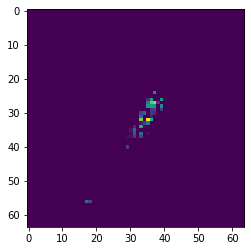

In [ ]:
plt.imshow(dataset[0])

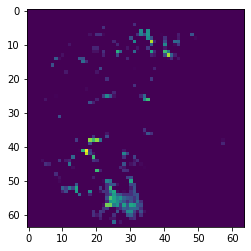

In [ ]:
plt.imshow(b_dataset_28[0])

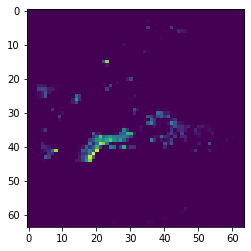

In [ ]:
plt.imshow(b_dataset_37[0])

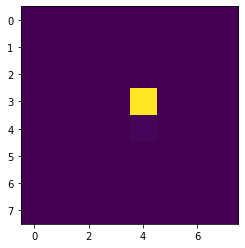

In [ ]:
plt.imshow(s_dataset[0])

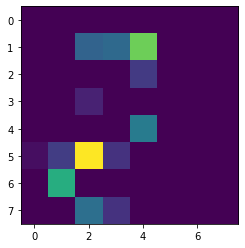

In [ ]:
plt.imshow(s_b_dataset[0])

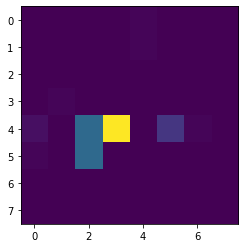

In [ ]:
plt.imshow(s_lb_dataset[0])

Questions:
<br>• Why do we need to balance the dataset between rainy and not rainy eventes?
<br>• What other methods could be used to balance this dataset?As a result we have now the following datasets: 

Answers:
<br>·Before balancing not rainy information dominates the dataset, which is bad for the model to learn from rainy days information (the proportion of rainy days is too small).
<br>·PCA can also be used to balance the dataset.

# Task 2 - Spatial Regression 

In this exercise, we are going to perform regression over images' spatial coordinates. In other words, given a specific position in the image, we want to infer the precipitation value of the center pixel (target) of small balanced dataset (8x8) which corresponds to X[4,4]. Features will be the neighbouring pixels of the center, you can see an example. The aim of this exercise is to analyze spatial regression performances using the information of neighbours (e.g., adjacent pixels). 

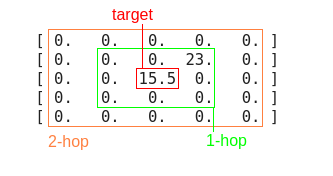

In [ ]:
from IPython.display import Image
Image("/drive/My Drive/ML/hop.png")

First, start with obtaining 3x3 matrices from each image and remove the center value as the target variable $y_reg$ using the small balanced dataset (!Warning: If you use np.delete(), make sure to first copy the data with np.copy(), otherwise you can delete the variable from the original dataset permanently). Then flatten the 3x3 matrices to obtain 8 features, since the center is removed, per sample in the feature matrix $X_{reg}$. After obtaining both $X_{reg}$ and $y_{reg}$, split into training and validation set by using $train\_test\_split$ function from sklearn where the random state is $4720$. Finally build K-Nearest Neighbour (KNN) regressor with 20 neighbours ($n\_neighbours=20$) and train the model with the training data. Test the model performance with the validation data using RMSE as the performance metric. Expand the same methodology by creating 5x5 and 7x7 matrices which is equivalent to taking second and the third adjacent pixels. 

In [ ]:
def dataset_generator(x, y, window_length, dataset):

  matrices = np.empty((dataset.shape[0], window_length, window_length))
  for image in range(dataset.shape[0]):
    matrix = dataset[image, x - int(window_length/2) : x + int(window_length/2) + 1, y - int(window_length/2) : y + int(window_length/2) + 1]
    matrices[image] = matrix

  middles = matrices[:, int(window_length/2), int(window_length/2)]
  middles = middles[:, np.newaxis]

  matrices_flatten = matrices.reshape(dataset.shape[0], window_length ** 2)
  matrices_flatten_8f = np.delete(matrices_flatten, window_length + int(window_length/2), axis=1)

  return matrices, matrices_flatten, matrices_flatten_8f, middles


In [ ]:
# For visualization purposes, create the Regression dataset and print the first sample to visualize it and make sure that everything 
# is correct. 

X_input_before, X_input_after, X_reg, Y_reg = dataset_generator(4, 4, 3, s_b_dataset)

print('Target:')
print(Y_reg[0])
print(str(3)+'-hop neighbors:')
print(X_input_before[0])

print('Flattened input:')
print(X_input_after[0])

print('Regression input (Targed has been removed):')
print(X_reg[0])

Target:
[8.5]
3-hop neighbors:
[[0.  0.  0. ]
 [0.  8.5 0. ]
 [3.  0.  0. ]]
Flattened input:
[0.  0.  0.  0.  8.5 0.  3.  0.  0. ]
Regression input (Targed has been removed):
[0. 0. 0. 0. 0. 3. 0. 0.]


In [215]:
def train_test(x_reg, y_reg, k):
  #Split dataset into train and eval using the 25% of data for validation

  X_train, X_val, y_train, y_val = train_test_split(x_reg, y_reg, test_size=0.25, random_state=4720)
  # Print sets dimentions 
  print('Sets sizes: X_train =', X_train.shape, ',cY_train = ', y_train.shape )
  print('Sets sizes: X_val =', X_val.shape, ', Y_val = ', y_val.shape )

  rmse = [] #to store rmse values for different k
  model = neighbors.KNeighborsRegressor(n_neighbors=20)
  model.fit(X_train, y_train)  #fit the model
  y_pre = model.predict(X_val) #make prediction on test set
  error = mean_squared_error(y_pre, y_val, squared=False) #calculate RMSE
  rmse.append(error) #store RMSE values
  print('RMSE value for k =' , k , 'is:',  f'{error:.6f}')  #print RMSE for different k values 

  # #Plot True targets against target predictions 
  plt.plot(y_val, label='True targets') 
  plt.plot(y_pre, label='Targets predictions')
  plt.legend()
  plt.show()

Sets sizes: X_train = (2436, 8) ,cY_train =  (2436, 1)
Sets sizes: X_val = (812, 8) , Y_val =  (812, 1)
RMSE value for k = 3 is: 9.585847


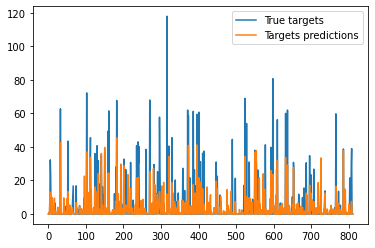

In [216]:
train_test(X_reg, Y_reg, k=3)

Apply the same procedure for the balanced dataset (64x64) but we have to consider more adjacent pixels. 5th, 7th, and 9th hops (adjacent pixels) will correspond to 7x7, 11x11 and 15x15 matrices before flatting to $X_{reg}$ and the center pixel should correspond to $y_{reg}$. Use the same number of neighbours in KNN regressor.

Sets sizes: X_train = (2436, 24) ,cY_train =  (2436, 1)
Sets sizes: X_val = (812, 24) , Y_val =  (812, 1)
RMSE value for k = 5 is: 6.663809


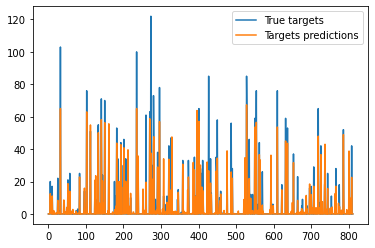

In [223]:
_, _, X_reg5, Y_reg5 = dataset_generator(32, 32, 5, b_dataset_28)
train_test(X_reg5, Y_reg5, k=5)

Sets sizes: X_train = (2436, 48) ,cY_train =  (2436, 1)
Sets sizes: X_val = (812, 48) , Y_val =  (812, 1)
RMSE value for k = 7 is: 7.503263


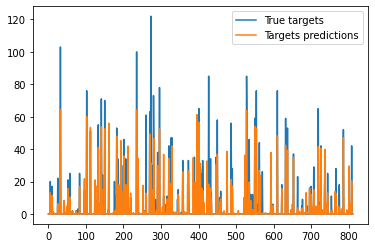

In [218]:
_, _, X_reg7, Y_reg7 = dataset_generator(32, 32, 7, b_dataset_28)
train_test(X_reg7, Y_reg7, k=7)

Sets sizes: X_train = (2436, 80) ,cY_train =  (2436, 1)
Sets sizes: X_val = (812, 80) , Y_val =  (812, 1)
RMSE value for k = 9 is: 8.204704


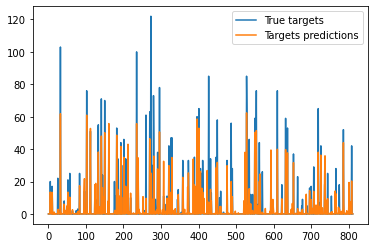

In [219]:
_, _, X_reg9, Y_reg9 = dataset_generator(32, 32, 9, b_dataset_28)
train_test(X_reg9, Y_reg9, k=9)

Questions:
<br>• Do we get better results using more pixels in the small balanced dataset and the balanced dataset? If yes/no, why?
<br>• Is the model underfitting or overfitting? Motivate the answer.

<br>· Using more pixels does not bring better results. It happens maybe because KNN method is sensitive to outliers. 
<br>· The model is underfitting, because when increase the size of the window from 5 to 19, the loss fluctuates around 9.5, which is relatively high. This meas the model fails to capture the features in the input dataset. It may be resulted by noisy and irregular input data values.

# Task 3 - Precipitation Forecasting

In this task, we are going to perform precipitation forecasting of the image averages. In order to do
that, we are going to use an autoregressive integrated moving average (ARIMA) model. ARIMA
model is a known model in time series analysis, It is used either to better understand the data or
to predict future points in the series (forecasting). In such analyses, the amount of data used to fit
the model also represents how far we can go back in time in our time series analysis and affect the
quality of the predicted points.


Using the original average precipitation dataset’s (8x8) first 2000 samples to train and obtain model
predictions with model.f it().f ittedvalues. Plot true data and fitted values in the same figure. Calculate and print the MSE.

In [187]:
arima_dataset = np.mean(np.mean(s_dataset[:2000], axis=1), axis=1).ravel()
model = ARIMA(arima_dataset, order=(0,0,1)) # ARIMA Initialization
prediction_arima = model.fit().fittedvalues

MSE= 3.1677624149224792


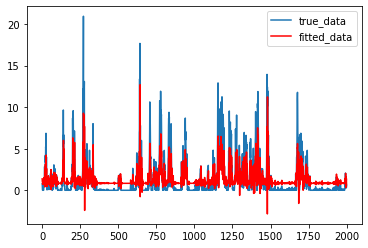

In [ ]:
plt.plot(arima_dataset, label='true_data')
plt.plot(prediction_arima, color='red', label='fitted_data')
MSE_error = mean_squared_error(arima_dataset, prediction_arima)
plt.legend()
print('MSE=', MSE_error)

Since the model is ready we can start predicting the future average precipitation values. Predict and the next (3, 5, 7, 12, 15) hours with the function $model.fit().predict(1, i)$ where $i$ is the future prediction window, compare the accuracy of such predictions using MSE. Plot both true and predicted future average precipitation.

MSE= 0.49573272662147744


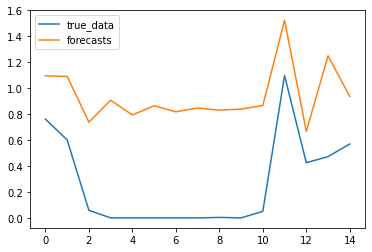

In [ ]:
hours = [3, 5, 7, 12, 15]

for i in [3, 5, 7, 12, 15]:
  yhat = model.fit().predict(1, i)

fig = plt.figure()
plt.plot(arima_dataset[ : 15], label='true_data')
plt.plot(yhat, label='forecasts')
plt.legend()

MSE_error = mean_squared_error(yhat, arima_dataset[ : 15])
print('MSE=', MSE_error)

Questions:
<br>• Do we get better results using more pixels in the small balanced dataset and the balanced
dataset? If yes/no, why?
<br>• Is the model underfitting or overfitting? Motivate the answer.

<br>· No. All the pixels are averaged and serve as a single scaler in the model. Even if we increase the number of pixels when averaging the daily precitipation images, no significant influence on the input model will be brought as most of the pixels have values=0. Therefore, no better results are yielded.
<br>· The model behaves well. Both the training and testing errors are small.

Task 4 - Extracting features using Principal Component Analysis (1 point)
======

Principal component analysis (PCA) is a statistical procedure that allows you to summarize the information content in large data tables by means of a smaller set of “summary indices” that can be more easily visualized and analyzed. In this case, we are going to extract the most relevant features from our data. We will do that using the sklearn package \url{https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html}. It is important to note in order to apply PCA we need to first flatten our data. Moreover, we can choose the dimensionality of the extracted features. 

Implement a PCA feature extractor with 30 principal components for each 6 datasets (original,
balanced, lightly balanced, small original, small balanced, and small lightly balanced).

<br>Extract the features from each 6 datasets

In [ ]:
N = 30 #number of principal components 
pca = PCA(n_components=N) # Initialize PCA
flattened_dataset = dataset.reshape(dataset.shape[0], -1) # samples flattening
features = pca.fit_transform(flattened_dataset) # feature extraction

In [ ]:
flattened_dataset_b = b_dataset_28.reshape(b_dataset_28.shape[0], -1) # samples flattening
features_b = pca.fit_transform(flattened_dataset_b) # feature extraction
print(features_b.shape)

(3248, 30)


In [ ]:
flattened_dataset_lb = b_dataset_37.reshape(b_dataset_37.shape[0], -1) # samples flattening
features_lb = pca.fit_transform(flattened_dataset_lb) # feature extraction
print(features_lb.shape)

(4872, 30)


In [ ]:
flattened_dataset_s = s_dataset.reshape(s_dataset.shape[0], -1) # samples flattening
features_s = pca.fit_transform(flattened_dataset_s) # feature extraction
print(features_s.shape)

(8119, 30)


In [ ]:
flattened_dataset_sb = s_b_dataset.reshape(s_b_dataset.shape[0], -1) # samples flattening
features_sb = pca.fit_transform(flattened_dataset_sb) # feature extraction
print(features_sb.shape)

(3248, 30)


In [ ]:
flattened_dataset_slb = s_lb_dataset.reshape(s_lb_dataset.shape[0], -1) # samples flattening
features_slb = pca.fit_transform(flattened_dataset_slb) # feature extraction
print(features_slb.shape)

(4872, 30)


Questions:
<br>• What are the limitations of the adopted approach?
<br>• How the dimensionality N affect the extracted features?

<br>· PCA sometimes losses important infomation.
<br>· The bigger N is, the more features are kept in the X dataset. But it does not promise give better prediction results as the information left behind may mainly contain noises.

# Task 5 - Classification of Rainy Events (3 points)

In this task we are going to classify images and the related extracted features as rainy or not rainy
events of the defined dataset. We will define a function Classifier that splits the given dataset
intro training and validation sets, fit the classification model, compute Accuracy, Recall, Precision,
F1, and AUC and plot both ROC curve and the confusion matrix.


Classifier function takes the following inputs: sklearn classification model, feature matrix Xin and
classification labels Yin. Train-test split uses 25% of the data as test data with the random state
as 4720. The function prints out Accuracy, Recall, Precision, F1 and AUC scores and plots confusion matrix, ROC curve of training and ROC curve of test data (either in same figure or different).
Two classic classifiers Logistic Regression and Decision Tree Classifier (random_state=4720) will be used for the binary
classification task at hand. Apply the following steps.

Develop the function Classifier

In [270]:
def Classifier(clf,X_input, Y_input):
  if X_input.ndim == 2:
    x = X_input.reshape(X_input.shape[0], -1)
  else:
    x = X_input.reshape(X_input.shape[0], -1)
  y = Y_input

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=4720)
  y_test.reshape(-1, 1)

  clf.fit(x_train, y_train)
  y_pred = clf.predict(x_test)
  accuracy = accuracy_score(y_pred, y_test)
  recall = recall_score(y_pred, y_test)
  precision = precision_score(y_pred, y_test)
  f1 = f1_score(y_pred, y_test)
  auc = roc_auc_score(y_pred, y_test)

  print("Accuracy: " + str(accuracy))
  print("F1 score: " + str(f1))
  print("Recall score: " + str(recall))
  print("Precision score: " + str(precision))
  print("AUC score: " + str(auc))

  confusion_matrix(y_test, y_pred)
  plot_confusion_matrix(clf, x_test, y_test)

  # train_disp = plot_roc_curve(clf, x_train, y_train, name='Train ROC')
  # test_disp = plot_roc_curve(clf, x_test, y_test, name='Test ROC')

In [228]:
clf_logistic = LogisticRegression()
clf_DTC = DecisionTreeClassifier()

Call the function with logistic regression and the original (flattened) dataset.

Accuracy: 0.7315270935960592
F1 score: 0.30038510911424904
Recall score: 0.20347826086956522
Precision score: 0.5735294117647058
AUC score: 0.5718422232182877


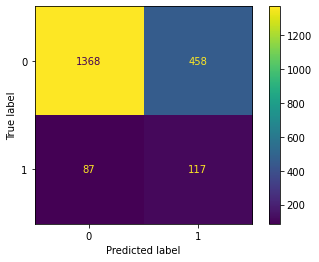

In [273]:
Classifier(clf_logistic, dataset, y_data.reshape(-1, 1))

Call the function with decision tree classifier and the original (flattened) dataset.

Accuracy: 0.9428571428571428
F1 score: 0.7070707070707071
Recall score: 0.7291666666666666
Precision score: 0.6862745098039216
AUC score: 0.847173104824084


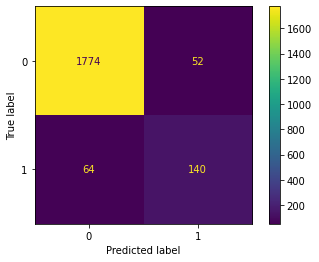

In [274]:
Classifier(clf_DTC, dataset, y_data.reshape(-1, 1))

Call the function with logistic regression and the small original (flattened) dataset

Accuracy: 0.993103448275862
F1 score: 0.968609865470852
Recall score: 0.968609865470852
Precision score: 0.968609865470852
AUC score: 0.9823680207265716


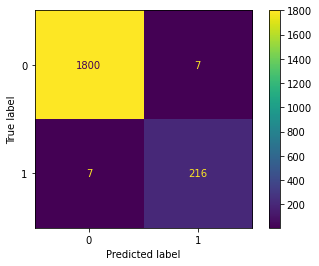

In [275]:
Classifier(clf_logistic, s_dataset, labels.reshape(-1, 1))

Call the function with decision tree classifier and the small original (flattened) dataset.

Accuracy: 0.9448275862068966
F1 score: 0.7320574162679427
Recall score: 0.7846153846153846
Precision score: 0.6860986547085202
AUC score: 0.8732341228254034


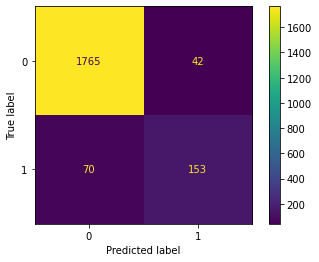

In [276]:
Classifier(clf_DTC, s_dataset, labels.reshape(-1, 1))

Call the function with logistic regression and the balanced (flattened) dataset

Accuracy: 0.6514778325123153
F1 score: 0.5398373983739838
Recall score: 0.4322916666666667
Precision score: 0.7186147186147186
AUC score: 0.6402112538940811


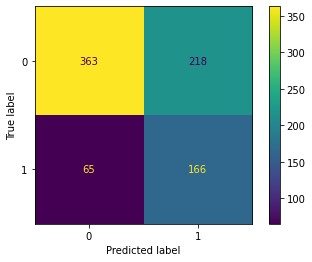

In [277]:
Classifier(clf_logistic, b_dataset_28, b_labels.reshape(-1, 1))

Call the function with decision tree class. and the balanced (flattened) dataset

Accuracy: 0.8460591133004927
F1 score: 0.7379454926624739
Recall score: 0.7154471544715447
Precision score: 0.7619047619047619
AUC score: 0.8091370047976097


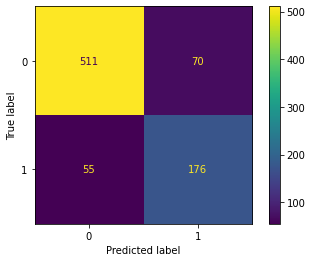

In [278]:
Classifier(clf_DTC, b_dataset_28, b_labels.reshape(-1, 1))

Call the function with logistic regression and the small balanced (flattened) dataset

Accuracy: 0.9901477832512315
F1 score: 0.982532751091703
Recall score: 0.9911894273127754
Precision score: 0.974025974025974
AUC score: 0.9904665085281825


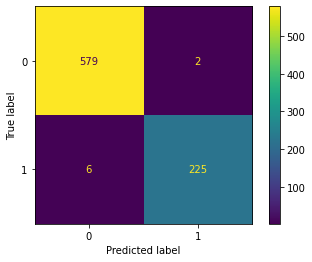

In [279]:
Classifier(clf_logistic, s_b_dataset, b_labels.reshape(-1, 1))

Call the function with decision tree class. and the small balanced (flattened) dataset

Accuracy: 0.8805418719211823
F1 score: 0.7810383747178329
Recall score: 0.8160377358490566
Precision score: 0.7489177489177489
AUC score: 0.8596855345911949


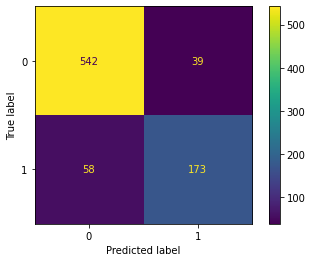

In [280]:
Classifier(clf_DTC, s_b_dataset, b_labels.reshape(-1, 1))

Call the function with logistic regression and the lightly balanced (flattened) dataset

Accuracy: 0.6502463054187192
F1 score: 0.3486238532110092
Recall score: 0.2556053811659193
Precision score: 0.5480769230769231
AUC score: 0.5669218615674156


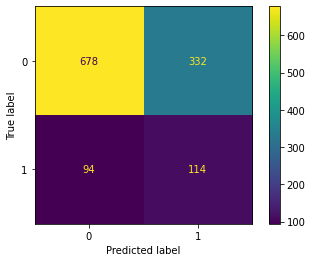

In [281]:
Classifier(clf_logistic, b_dataset_37, y_data_lbalanced.reshape(-1, 1))

Call the function with decision tree class. and the lightly balanced (flattened) dataset

Accuracy: 0.8899835796387521
F1 score: 0.6510416666666665
Recall score: 0.7102272727272727
Precision score: 0.6009615384615384
AUC score: 0.8152863810853254


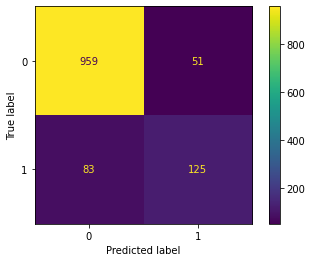

In [282]:
Classifier(clf_DTC, b_dataset_37, y_data_lbalanced.reshape(-1, 1))

Call the function with logistic regression and the small lightly balanced (flattened) dataset

Accuracy: 0.9901477832512315
F1 score: 0.972972972972973
Recall score: 0.972972972972973
Precision score: 0.972972972972973
AUC score: 0.9834744382937154


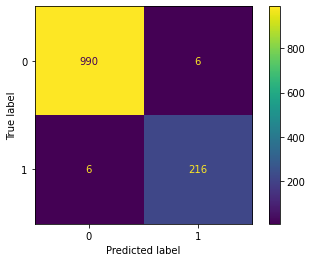

In [283]:
Classifier(clf_logistic, s_lb_dataset, lb_labels.reshape(-1, 1))

Call the function with decision tree class. and the small lightly balanced (flattened) dataset

Accuracy: 0.8957307060755336
F1 score: 0.702576112412178
Recall score: 0.7317073170731707
Precision score: 0.6756756756756757
AUC score: 0.8303156526135843


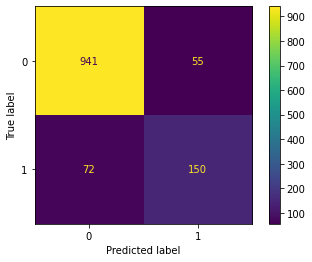

In [284]:
Classifier(clf_DTC, s_lb_dataset, lb_labels.reshape(-1, 1))

Repeat the previous steps with the extracted features as well. Write down your observations about
different models, datasets and feature extraction. Answer the following questions.


###  Classification of rainy events using PCA extracted features 

Now let's classify rainy events using just PCA extracted features. Do it for all datasets and compare logistic and Decition Tree classifiers

Accuracy: 0.996551724137931
F1 score: 0.9828009828009828
Recall score: 0.9852216748768473
Precision score: 0.9803921568627451
AUC score: 0.9915161466885605


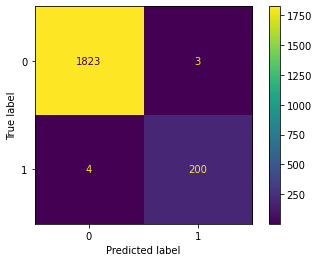

In [285]:
Classifier(clf_logistic, features, y_data.reshape(-1, 1))

Accuracy: 0.9916256157635468
F1 score: 0.9590361445783132
Recall score: 0.943127962085308
Precision score: 0.9754901960784313
AUC score: 0.9701895995143417


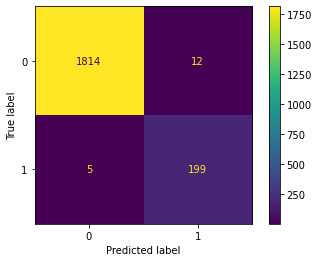

In [286]:
Classifier(clf_DTC, features, y_data.reshape(-1, 1))

Accuracy: 0.9935960591133005
F1 score: 0.9711751662971174
Recall score: 0.9605263157894737
Precision score: 0.9820627802690582
AUC score: 0.9791532799813073


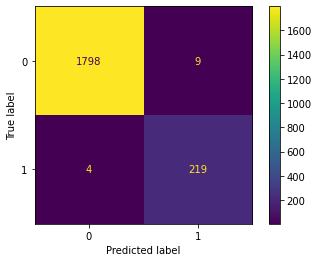

In [287]:
Classifier(clf_logistic, features_s, labels.reshape(-1, 1))

Accuracy: 0.9896551724137931
F1 score: 0.9536423841059603
Recall score: 0.9391304347826087
Precision score: 0.968609865470852
AUC score: 0.9676207729468598


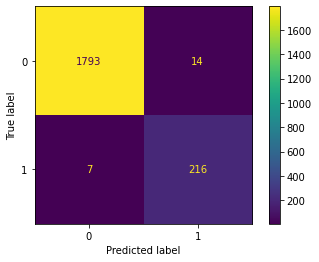

In [288]:
Classifier(clf_DTC, features_s, labels.reshape(-1, 1))

Accuracy: 0.9519704433497537
F1 score: 0.9131403118040089
Recall score: 0.9403669724770642
Precision score: 0.8874458874458875
AUC score: 0.9482979643530102


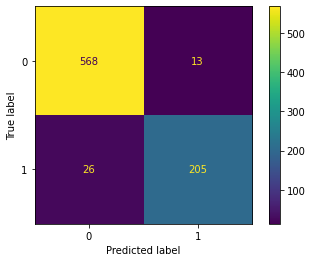

In [289]:
Classifier(clf_logistic, features_b, b_labels.reshape(-1, 1))

Accuracy: 0.916256157635468
F1 score: 0.8547008547008548
Recall score: 0.8438818565400844
Precision score: 0.8658008658008658
AUC score: 0.8949844065309117


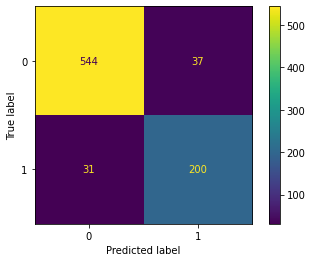

In [290]:
Classifier(clf_DTC, features_b, b_labels.reshape(-1, 1))

Accuracy: 0.9901477832512315
F1 score: 0.9826839826839827
Recall score: 0.9826839826839827
Precision score: 0.9826839826839827
AUC score: 0.987899650550253


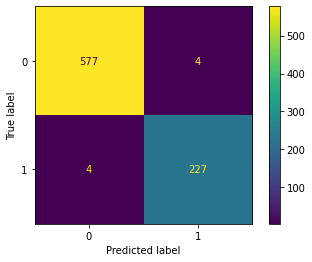

In [291]:
Classifier(clf_logistic, features_sb, b_labels.reshape(-1, 1))

Accuracy: 0.9716748768472906
F1 score: 0.9487750556792872
Recall score: 0.9770642201834863
Precision score: 0.922077922077922
AUC score: 0.973380594940228


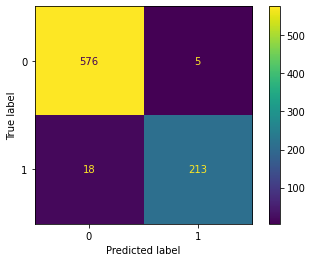

In [292]:
Classifier(clf_DTC, features_sb, b_labels.reshape(-1, 1))

Accuracy: 0.9967159277504105
F1 score: 0.9903846153846154
Recall score: 0.9903846153846154
Precision score: 0.9903846153846154
AUC score: 0.9942022086824067


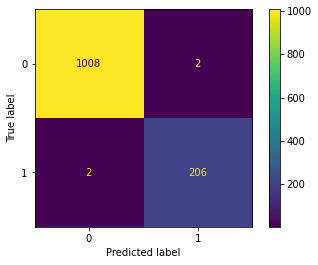

In [293]:
Classifier(clf_logistic, features_lb, y_data_lbalanced.reshape(-1, 1))

Accuracy: 0.9893267651888341
F1 score: 0.9688249400479617
Recall score: 0.9665071770334929
Precision score: 0.9711538461538461
AUC score: 0.980280347684239


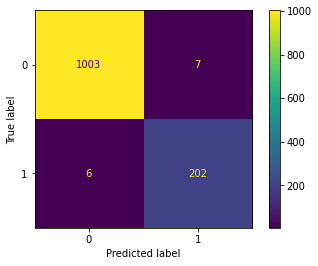

In [294]:
Classifier(clf_DTC, features_lb, y_data_lbalanced.reshape(-1, 1))

Accuracy: 0.9885057471264368
F1 score: 0.9684684684684683
Recall score: 0.9684684684684685
Precision score: 0.9684684684684685
AUC score: 0.9807201780093346


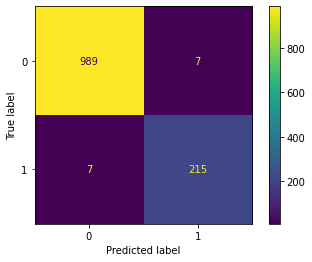

In [295]:
Classifier(clf_logistic, features_slb, lb_labels.reshape(-1, 1))

Accuracy: 0.964696223316913
F1 score: 0.9038031319910514
Recall score: 0.8977777777777778
Precision score: 0.9099099099099099
AUC score: 0.9388183954347097


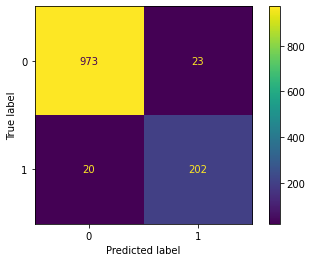

In [296]:
Classifier(clf_DTC, features_slb, lb_labels.reshape(-1, 1))

Questions:
<br>• What differences do you find between train and test ROC curves in logistic regression and the Decision Tree model? Elaborate on those differences.
<br>• What does the confusion matrix of the decision tree classifier applied to the balanced dataset show? Explain your observations.
<br>• Plot ROC curve and confusion matrix of logistic regression classifier and Decision Tree Classifier.
<br>• Compare the results you got by classifying directly images and classifying the related features.To what extent the results we get are correct? What phenomenon are we observing when we use unbalanced datasets?
<br>• What methods could be used to fix such behaviours?

Answers:
<br>· The ROC curves of training set are better than the test sets as they cover more area. It is reasonable because most models have the same tendency of overfitting on the training set, therefore have lower classification error on the training set.
<br>· It shows only 50 + 77 = 127 samples are misclassifed and others are classified successfully.
<br>· Plotted in the code blocks.
<br>· Classification using features selected by PCA gives better results. The results are reliable because high consistency of the high precision is observed in the PCA predictions. When classifying using unbalanced dataset selected features, more misclassifications are observed. It is reasonble because the proportion of rainy pixels is small and it is too few for the model to learn from.
<br>· Using unsampling, oversampling and sampling manually can solve the problem.